In [49]:
# initialize dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader
import random

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


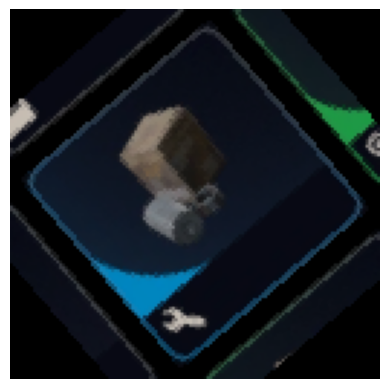

In [50]:
# prepare datasets
# import png images from 'arc-raiders-items' folder. Label is folder name, images below are training images.
composedTransforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

train_ds = torchvision.datasets.ImageFolder(
    root="./arc-raiders-items",
    transform=composedTransforms,
    )

train_dataset_gpu = [(image.to(device), label) for image, label in train_ds]

train_dl_gpu = DataLoader(
    dataset=train_dataset_gpu,
    batch_size=64,
    shuffle=True,
    generator=torch.Generator(device)
)

# display random image from dataset to ensure it has loaded properly
index = random.randrange(0, len(train_ds) - 1)
image, label = train_ds[index]

import matplotlib.pyplot as plt
plt.imshow(torch.Tensor(image).cpu().permute(1, 2, 0))  # change from CxHxW to HxWxC
plt.axis("off")
plt.show()


In [66]:
# init neuralnet
net = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(16 * 16 * 128, 256),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256,256),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, len(train_ds)),
).cuda()

loss_fn = nn.CrossEntropyLoss() # standard loss function for multi-class classification
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001) # Adam optimizer with low learning rate

In [83]:
# training loop

num_epochs = 50
batch_size = 64

net.train()  # Set model to training mode

for epoch in range(num_epochs):
    for images, labels in train_dl_gpu:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # forward pass (make a prediction)
        logits = net(images)
        loss = loss_fn(logits, labels)

        # good old fashioned back propogation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# set model to eval mode
net.eval()


Epoch [1/50], Loss: 0.1498
Epoch [2/50], Loss: 0.1973
Epoch [3/50], Loss: 0.1683
Epoch [4/50], Loss: 0.3072
Epoch [5/50], Loss: 0.1645
Epoch [6/50], Loss: 0.1699
Epoch [7/50], Loss: 0.1245
Epoch [8/50], Loss: 0.1920
Epoch [9/50], Loss: 0.0955
Epoch [10/50], Loss: 0.2749
Epoch [11/50], Loss: 0.2079
Epoch [12/50], Loss: 0.2060
Epoch [13/50], Loss: 0.2035
Epoch [14/50], Loss: 0.2794
Epoch [15/50], Loss: 0.3792
Epoch [16/50], Loss: 0.2539
Epoch [17/50], Loss: 0.2289
Epoch [18/50], Loss: 0.3079
Epoch [19/50], Loss: 0.1771
Epoch [20/50], Loss: 0.3359
Epoch [21/50], Loss: 0.1097
Epoch [22/50], Loss: 0.1583
Epoch [23/50], Loss: 0.1911
Epoch [24/50], Loss: 0.2512
Epoch [25/50], Loss: 0.1856
Epoch [26/50], Loss: 0.2181
Epoch [27/50], Loss: 0.2550
Epoch [28/50], Loss: 0.1650
Epoch [29/50], Loss: 0.2063
Epoch [30/50], Loss: 0.3015
Epoch [31/50], Loss: 0.2424
Epoch [32/50], Loss: 0.3466
Epoch [33/50], Loss: 0.1397
Epoch [34/50], Loss: 0.1339
Epoch [35/50], Loss: 0.2612
Epoch [36/50], Loss: 0.1858
E

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=32768, out_features=256, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=256, out_features=256, bias=True)

# mostly util stuff below this

Predicted: [191, 140, 47, 209, 14], Actual: [191, 140, 47, 182, 14]


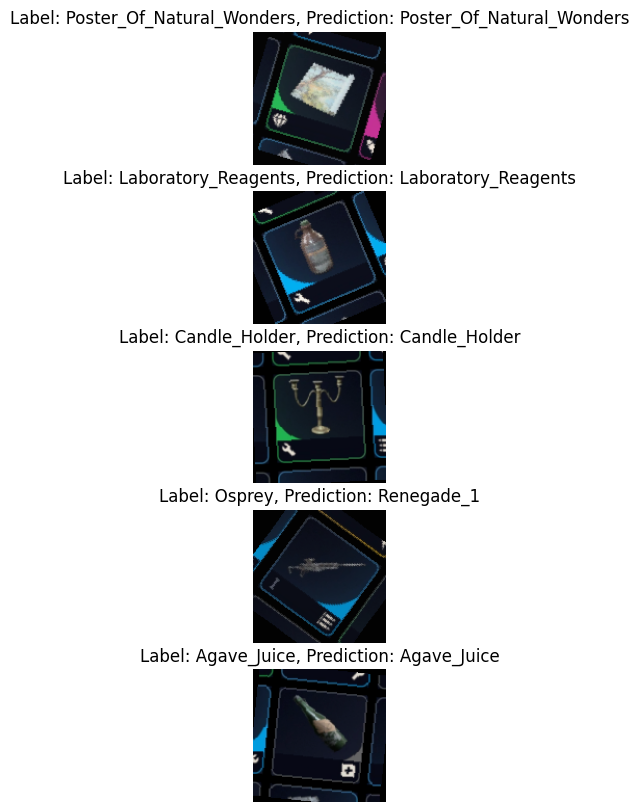

In [86]:
# predict on random images
# select random image set and predict
randomIndices = [random.randrange(0, len(train_ds)) for _ in range(5)]
images = []
labels = []
for i in range(5):
    img, lbl = train_ds[randomIndices[i]]
    images.append(img)
    labels.append(lbl)

# infer on GPU

images = torch.stack(images).to(device)  # create batch
logits = net(images)
predicted_labels = logits.argmax(dim=1).tolist()

# Get class names from ImageFolder
dataset_classes = torchvision.datasets.ImageFolder(root="./arc-raiders-items").classes

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {predicted_labels}, Actual: {labels}")
cnt = 0
for ax in axes:
    img, lbl = train_ds[randomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

In [87]:
import copy

net.eval()


# Save neural net weights
torch.save(net.state_dict(), "arcraiders_model.pth")

# save ONNX
dummy_input = torch.randn(1, 3, 128, 128)
torch.onnx.export(net, dummy_input, "arcraiders_model.onnx", opset_version=17, do_constant_folding=True)

W1130 18:37:49.961000 188286 /home/od/.pyenv/versions/3.13.9/envs/jup/lib/python3.13/site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 17).


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 17},
            producer_name='pytorch',
            producer_version='2.9.1+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,128,128]>
            ),
            outputs=(
                %"linear_2"<FLOAT,[1,3070]>
            ),
            initializers=(
                %"0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"0.bias"<FLOAT,[32]>{Tensor(...)},
                %"4.bias"<FLOAT,[64]>{Tensor(...)},
                %"8.bias"<FLOAT,[128]>{Tensor(...)},
                %"13.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"16.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"4.weight"<FLOAT,[64,32,3,3]>{Tensor(...)},
                %"8.weight"<FLOAT,[128,64,3,3]>{Tensor(...)},
                %"13.weight"<FLOAT,[256,32768]>{TorchTensor(...

In [ ]:
# test CPU inference speed
import time

# import net from file init datasets
if cpu_net is None:
    cpu_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 64 * 3, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, len(dataset_classes)),
    )
    cpu_net.load_state_dict(torch.load("arcraiders_model.pth"))
    cpu_net.to("cpu")

# prepare random input
cpuRandomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
cpuImages = []
cpuLabels = []
for i in range(5):
    img, lbl = train_dataset[cpuRandomIndices[i]]
    cpuImages.append(img)
    cpuLabels.append(lbl)

random_input = torch.stack(cpuImages)  # create batch
# warm up
_ = cpu_net(random_input)
# measure time
start_time = time.time()
_ = cpu_net(random_input)
end_time = time.time()
print(f"CPU inference time: {end_time - start_time:.6f} seconds")

# infer on GPU

cpuImages = torch.stack(cpuImages) # create batch
cpuLogits = net(cpuImages)
cpu_predicted_labels = cpuLogits.argmax(dim=1).tolist()

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {cpu_predicted_labels}, Actual: {cpuLabels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[cpuRandomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[cpu_predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

CPU inference time: 0.014972 seconds


RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

In [27]:
# output classes to json
import json
with open("arcraiders_classes.json", "w") as f:
    json.dump(dataset_classes, f)